# Comprehensive Chorus Example: GATA1 Regulatory Analysis with Enformer

This notebook demonstrates all major features of the Chorus library using the Enformer oracle to analyze the GATA1 transcription start site (TSS) region.

GATA1 is an essential transcription factor for red blood cell development, making it an interesting target for regulatory analysis.

## Installation Instructions (Reference)

If you haven't installed Chorus yet, follow these steps:

```bash
# 1. Clone the repository
git clone https://github.com/pinellolab/chorus.git
cd chorus

# 2. Create the main Chorus environment
mamba env create -f environment.yml
mamba activate chorus

# 3. Install Chorus package
pip install -e .

# 4. Set up the Enformer environment
chorus setup --oracle enformer

# 5. Download the reference genome
chorus genome download hg38
```

**Note**: 
- For this notebook, we assume Chorus is already installed.
- pyGenomeTracks is now included in the environment for advanced visualization!

# Setup and Imports

In [1]:
# Import required libraries
import chorus
from chorus.utils import get_genome, extract_sequence, download_gencode
from chorus.utils.visualization import visualize_chorus_predictions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Set up matplotlib for inline display
import matplotlib
matplotlib.use('Agg')  # Use non-interactive backend
import matplotlib.pyplot as plt

# Set up plotting with white background
%matplotlib inline
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.dpi'] = 100  # Increase DPI for better quality

print("Chorus version:", chorus.__version__ if hasattr(chorus, '__version__') else "development")

Chorus version: 0.1.0


# 1. Setting Up Reference Genome and Annotations

Oracles predictions are done on the **reference genome**. Chorus downloads for you both the reference genome and annotations file if not already available on your paths.

In [2]:
# Download gene annotations
print("\nSetting up gene annotations...")
gtf_path = download_gencode(version='v48', annotation_type='basic')
print(f"Using annotations: {gtf_path}")

# Get reference genome (auto-downloads if not present)
print("Setting up reference genome...")
genome_path = get_genome('hg38')
print(f"Using genome: {genome_path}")

2025-12-01 12:40:40,459 - chorus.utils.annotations - INFO - Annotation file already exists: /storage_1/lruggeri/projects/chorus/annotations/gencode.v48.basic.annotation.gtf



Setting up gene annotations...
Using annotations: /storage_1/lruggeri/projects/chorus/annotations/gencode.v48.basic.annotation.gtf
Setting up reference genome...
Using genome: /storage_1/lruggeri/projects/chorus/genomes/hg38.fa


# 2. Create an Oracle

**Oracles** are the main objects in Chorus. They manages models that can make predictions on the genome. Let's start by downloading [Enformer](https://www.nature.com/articles/s41592-021-01252-x), a state-of-the-art sequence-to-activity models that can predict **5.313 human genomic tracks** with a context window of 196 kbp.

In [3]:
oracle = chorus.create_oracle(
    'enformer', 
    use_environment=True,
    reference_fasta=str(genome_path)
)

# Load pre-trained model
oracle.load_pretrained_model()
print("Model loaded successfully!")

2025-12-01 12:40:42,629 - chorus.core.base - INFO - Device: auto-detect (GPU if available, else CPU)
2025-12-01 12:40:42,635 - chorus.core.environment.manager - INFO - Found conda via CONDA_EXE: /storage_1/lruggeri/miniforge3/bin/conda
2025-12-01 12:40:42,635 - chorus.core.environment.manager - INFO - Found mamba at: /storage_1/lruggeri/miniforge3/bin/mamba
2025-12-01 12:40:45,172 - chorus.core.base - INFO - Using conda environment: chorus-enformer
2025-12-01 12:40:45,172 - chorus.oracles.enformer - INFO - Loading Enformer model from https://tfhub.dev/deepmind/enformer/1...
2025-12-01 12:40:47,678 - chorus.oracles.enformer - INFO - Enformer model loaded successfully in environment!


Model loaded successfully!


# 2.1 Exploring Available Tracks

**Chorus** let's you navigate easily on the *tracks* supported by each model. Here we explore:
1. The available assay types
2. The available cell types
2. The number of *tracks* for each assay type

In [4]:
# List available assay types
assay_types = oracle.list_assay_types()
print(f"Available assay types ({len(assay_types)}):")
for i, assay in enumerate(assay_types, 1):
    print(f"  {i:2d}. {assay}")

print("\n" + "="*50 + "\n")

# List available cell types (show first 5 due to large number)
cell_types = oracle.list_cell_types()
print(f"Available cell types ({len(cell_types)}):")
for i, cell in enumerate(cell_types[:5], 1):
    print(f"  {i:2d}. {cell}")
print(f"  ... and {len(cell_types) - 5} more")

# Get track summary
print("\n" + "="*50 + "\n")
track_summary = oracle.get_track_info()
print("Track summary by assay type:")
for assay, count in track_summary.items():
    print(f"  {assay}: {count} tracks")

2025-12-01 12:40:49,387 - chorus.oracles.enformer_source.enformer_metadata - INFO - Loaded 5313 track metadata entries


Available assay types (4):
   1. ATAC
   2. CAGE
   3. CHIP
   4. DNASE


Available cell types (1267):
   1. 3xFLAG-AHR
   2. 3xFLAG-ARID4B
   3. 3xFLAG-ATF1
   4. 3xFLAG-ATF4
   5. 3xFLAG-BCL6
  ... and 1262 more


Track summary by assay type:
  ATAC: 10 tracks
  CAGE: 638 tracks
  CHIP: 3991 tracks
  DNASE: 674 tracks


For this analysis we will focus on **K562**: a human leukemia cell line. We would like to see *chromatin accessibility* (DNase-seq) together with *gene expression* (CAGE-seq) tracks in such cells.

In [5]:
# Check our target tracks
print("K562 tracks available:")

# Search for K562 tracks
dnase_k562 = oracle.get_track_info("DNASE:K562")
cage_k562 = oracle.get_track_info("CAGE:.*K562")

print(f"\nDNASE:K562 - {len(dnase_k562)} tracks found")
if len(dnase_k562) > 0:
    print("First 3:")
    for idx, row in dnase_k562.head(3).iterrows():
        print(f"  - {row['identifier']}: {row['description']}")

print(f"\nCAGE with K562 - {len(cage_k562)} tracks found")
if len(cage_k562) > 0:
    print("All CAGE K562 tracks:")
    for idx, row in cage_k562.iterrows():
        print(f"  - {row['identifier']}: {row['description']}")

# Define the specific track IDs we'll use
print("\n" + "="*50)
print("\nFor this analysis, we'll use these specific track IDs:")
track_ids = ['ENCFF413AHU', 'CNhs11250'] #'ENCFF136DBS'] # the last is DNASE:HepG2
print(f"  - {track_ids[0]} (DNASE:K562)")
print(f"  - {track_ids[1]} (CAGE:chronic myelogenous leukemia cell line:K562)")

K562 tracks available:

DNASE:K562 - 7 tracks found
First 3:
  - ENCFF899YDP: DNASE:K562 treated with 1 uM vorinostat for 72 hours
  - ENCFF515UNC: DNASE:K562 G2 phase
  - ENCFF708UIS: DNASE:K562 G1 phase

CAGE with K562 - 2 tracks found
All CAGE K562 tracks:
  - CNhs11250: CAGE:chronic myelogenous leukemia cell line:K562
  - CNhs12336: CAGE:chronic myelogenous leukemia cell line:K562 ENCODE, biol_


For this analysis, we'll use these specific track IDs:
  - ENCFF413AHU (DNASE:K562)
  - CNhs11250 (CAGE:chronic myelogenous leukemia cell line:K562)


### Define Helper Functions

In [6]:
# Helper Function to plot comparison between different tracks
# No need for custom save_predictions_as_bedgraph - use oracle's method

def plot_track_comparison(tracks_dict, title="Track Comparison", window=None):
    """Plot multiple tracks for comparison using improved visualization."""
    # Convert to list format for visualization function
    track_ids = list(tracks_dict.keys())
    
    # Create a temporary figure to get the data
    import tempfile
    with tempfile.NamedTemporaryFile(suffix='.png', delete=True) as tmp:
        visualize_chorus_predictions(
            predictions=tracks_dict,
            chrom='chrX',
            start=0,  # Will be adjusted by window
            track_ids=track_ids,
            output_file=None,  # Display inline
            bin_size=1  # Since we're using pre-binned data
        )
    
    return plt.gcf()

## Example A: Wild-type Sequence Prediction

First, let's analyze the wild-type **GATA1** TSS region on *chromosome X*.

In [7]:
# Define GATA1 TSS region
gata1_region = "chrX:48777634-48790694"
print(f"Analyzing wild-type region: {gata1_region}")
print("This region contains the GATA1 transcription start site\n")

# Extract sequence information
wt_seq = extract_sequence(gata1_region, str(genome_path))
print(f"Region length: {len(wt_seq):,} bp")
print(f"GC content: {(wt_seq.count('G') + wt_seq.count('C')) / len(wt_seq) * 100:.1f}%")

Analyzing wild-type region: chrX:48777634-48790694
This region contains the GATA1 transcription start site

Region length: 13,061 bp
GC content: 47.2%


Now we are ready to make predictions!

## GATA1 Predictions using Chorus

Making predictions with **Chorus** is really simple! You just need to provide the *input coordinates* and the *tracks* to your oracle and Chorus will do the job.

In [8]:
# Make predictions for wild-type sequence
print("Making predictions using specific track identifiers...")
print(f"Track IDs: {track_ids}")

wt_results = oracle.predict(
    ('chrX', 48777634, 48790694),
    track_ids  # Using specific track IDs
)

Making predictions using specific track identifiers...
Track IDs: ['ENCFF413AHU', 'CNhs11250']
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import os
import json 
#import pandas as pd
from chorus.oracles.enformer_source.enformer_metadata import get_metadata

with open("/tmp/tmpsk0aupd5.txt") as inp:  # to be formatted by calling script 
    args = json.load(inp)


# Configure device
device = args['device']
if device:
    if device == 'cpu':
        os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    elif device.startswith('cuda:'):
        gpu_id = device.split(':')[1]
        os.environ['CUDA_VISIBLE_DEVICES'] = gpu_id

# Read sequence from file
seq = args['sequence']


# Load model (cached in TFHub)
# Enformer model has a specific structure - we need to get the model attribute
enformer = hub.load(args['model_weights'])
model = enformer.model

# One-hot encode
mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
one_hot = np.zeros((len(seq), 4), dtype=np.float32)

for i, ba

You can also save your predictions as *bedgraph* file format. 

In [9]:
# Save tracks using oracle method - Enformer handles coordinate mapping internally
print("\nSaving wild-type tracks...")
wt_files = wt_results.save_predictions_as_bedgraph(
    output_dir="bedgraph_outputs",
    prefix='a_wt'
)

print(f"Saved {len(wt_files)} files to bedgraph_outputs/")


Saving wild-type tracks...
Saved 2 files to bedgraph_outputs/



Creating visualization with gene annotations...


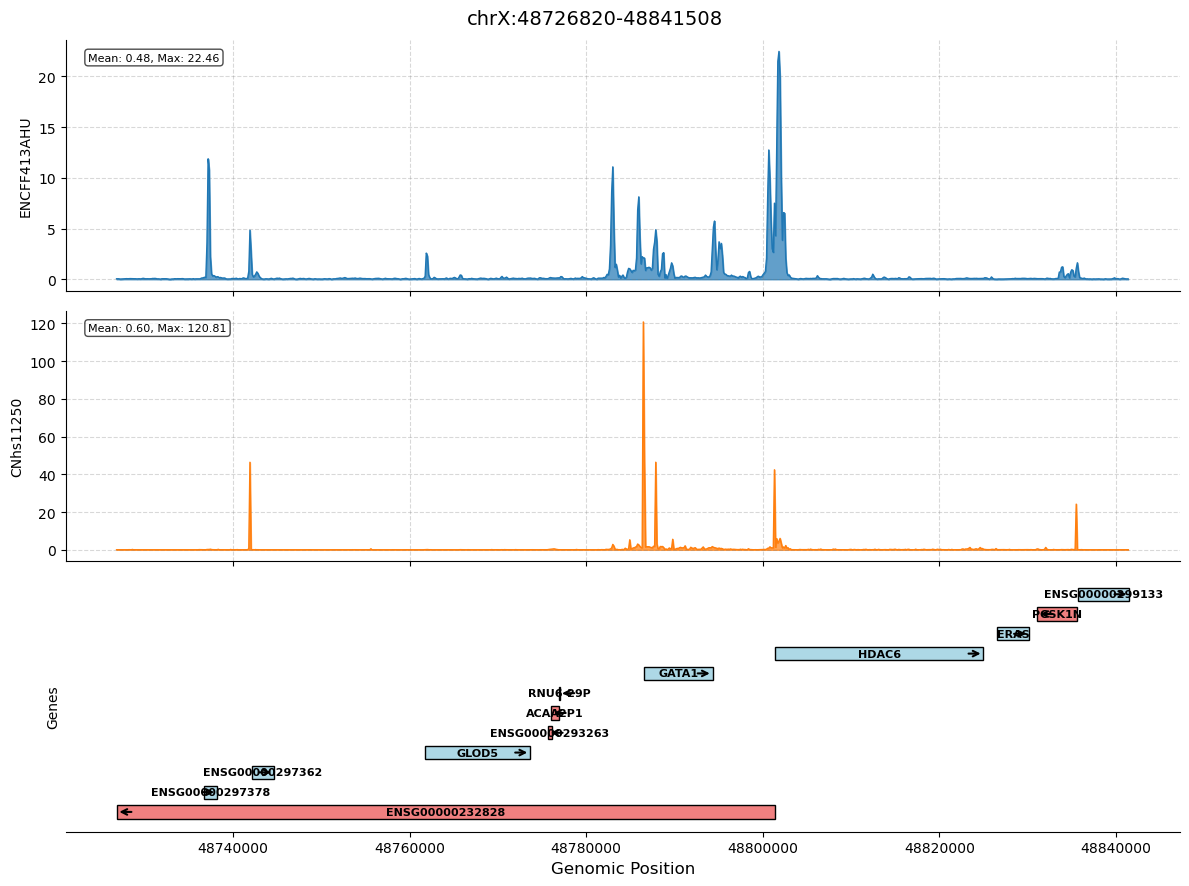

In [10]:
# Helper function - Visualize Chorus Predictions
# Create visualization with gene annotations using pyGenomeTracks
print("\nCreating visualization with gene annotations...")
try:
    visualize_chorus_predictions(
        predictions=wt_results,
        track_ids=track_ids,
        output_file=None,  # Display inline
        gtf_file=str(gtf_path),  # Add gene annotations
        use_pygenometracks=False  # Use pyGenomeTracks for better gene visualization
    )
    # print("Saved visualization to: gata1_wt_with_genes.png")
    
    # Display the saved image
    # from IPython.display import Image, display
    # display(Image('gata1_wt_with_genes.png', width=800))
    
except Exception as e:
    print(f"Could not create pyGenomeTracks visualization: {e}")
    print("Falling back to matplotlib visualization...")
    
    # Fallback to matplotlib for inline display
    visualize_chorus_predictions(
        predictions=wt_results,
        track_ids=track_ids,
        output_file=None,  # Display inline
        gtf_file=str(gtf_path),
        use_pygenometracks=False
    )
finally:
    pass

*Et voilà!* In just few lines of code we have both *chromatin accessibility* and *gene expression* tracks for GATA1, together with a nice visualization with annotations.

Now let's say that we want to use another model, like ChromBPNet, to compare the DNASE tracks.

## ChromBPNet Oracle

[ChromBPNet](https://pubmed.ncbi.nlm.nih.gov/39829783/) is a deep learning DNA sequence model of *base-resolution* accessibility profiles. This means that we'll only focus on **DNASE-seq** tracks here.

First we need to create the oracle

In [11]:
chrombpnet_oracle = chorus.create_oracle(
    'chrombpnet', 
    use_environment=True,
    reference_fasta=str(genome_path)
)

2025-12-01 12:41:41,713 - chorus.core.base - INFO - Device: auto-detect (GPU if available, else CPU)
2025-12-01 12:41:41,714 - chorus.core.environment.manager - INFO - Found conda via CONDA_EXE: /storage_1/lruggeri/miniforge3/bin/conda
2025-12-01 12:41:41,714 - chorus.core.environment.manager - INFO - Found mamba at: /storage_1/lruggeri/miniforge3/bin/mamba
2025-12-01 12:41:42,896 - chorus.core.base - INFO - Using conda environment: chorus-chrombpnet


And then we load the corresponding model

In [12]:
chrombpnet_oracle.load_pretrained_model(
    assay="DNASE",
    cell_type="K562",
)

2025-12-01 11:10:31,748 - chorus.oracles.chrombpnet - INFO - Dowloading ChromBPNet into /storage_1/lruggeri/projects/chorus/downloads/chrombpnet/DNASE_K562...
2025-12-01 11:12:32,344 - chorus.oracles.chrombpnet - INFO - Dowload completed!
2025-12-01 11:12:35,600 - chorus.oracles.chrombpnet - INFO - Loading ChromBPNet model...


Loading in environment


2025-12-01 11:12:37,894 - chorus.oracles.chrombpnet - INFO - ChromBPNet model loaded successfully in environment!


Now it's time to make **predictions**

In [13]:
tracks = ['DNASE:K562'] 

chrombpnet_results = chrombpnet_oracle.predict(
    ("chrX", 48_730_000, 48_840_000), # Here we need to extend to match Enformer context length
    tracks
)

# Save predictions as bedgraph
bpnet_results = chrombpnet_results.save_predictions_as_bedgraph(
    output_dir="bedgraph_outputs",
    prefix="a_wt_chrombpnet"
)


Creating visualization with gene annotations...


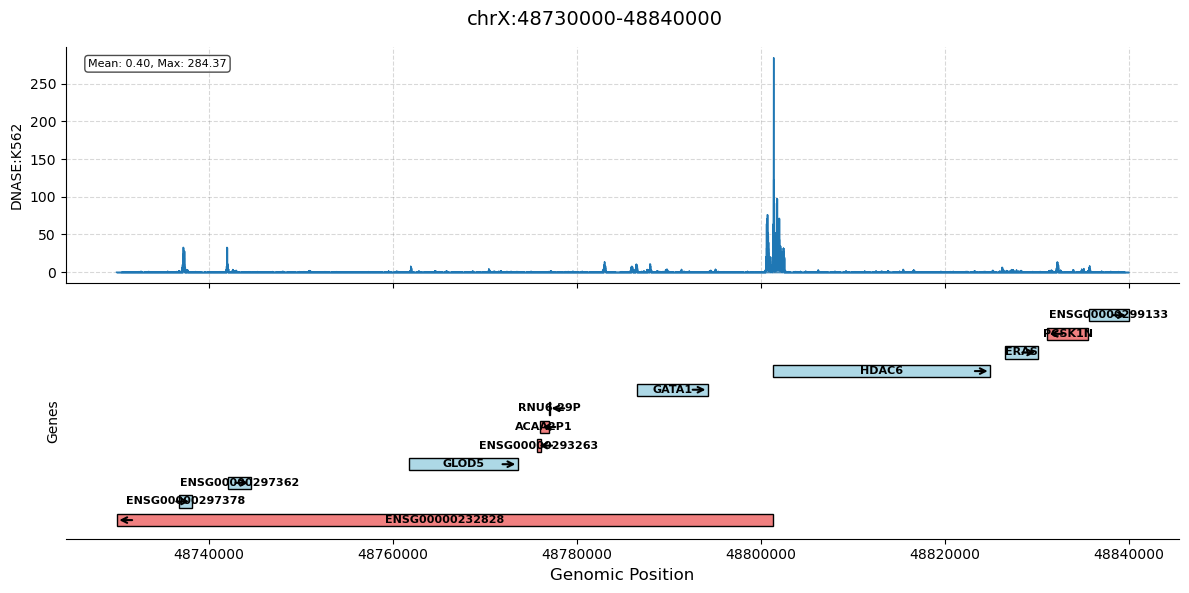

In [14]:
# Helper function - Visualize Chorus Predictions
from chorus.utils.visualization import visualize_chorus_predictions

# For visualization, get the output window coordinates
# Create visualization with gene annotations using pyGenomeTracks
print("\nCreating visualization with gene annotations...")
try:
    visualize_chorus_predictions(
        predictions=chrombpnet_results,
        track_ids=['DNASE:K562'],
        output_file=None,  # Display inline
        gtf_file=str(gtf_path),  # Add gene annotations
        use_pygenometracks=False  # Use pyGenomeTracks for better gene visualization
    )
    # print("Saved visualization to: gata1_wt_with_genes.png")
    
    # Display the saved image
    # from IPython.display import Image, display
    # display(Image('gata1_wt_with_genes.png', width=800))
    
except Exception as e:
    print(f"Could not create pyGenomeTracks visualization: {e}")
    print("Falling back to matplotlib visualization...")
    
    # Fallback to matplotlib for inline display
    visualize_chorus_predictions(
        predictions=chrombpnet_results,
        track_ids=['DNASE:K562'],
        output_file=None,  # Display inline
        gtf_file=str(gtf_path),
        use_pygenometracks=False
    )
finally:
    pass

And now you have predictions coming also from ChromBPNet!

Moreover, we can utilize **coolbox** to plot predictions side by side to better visualize differences between the two models.

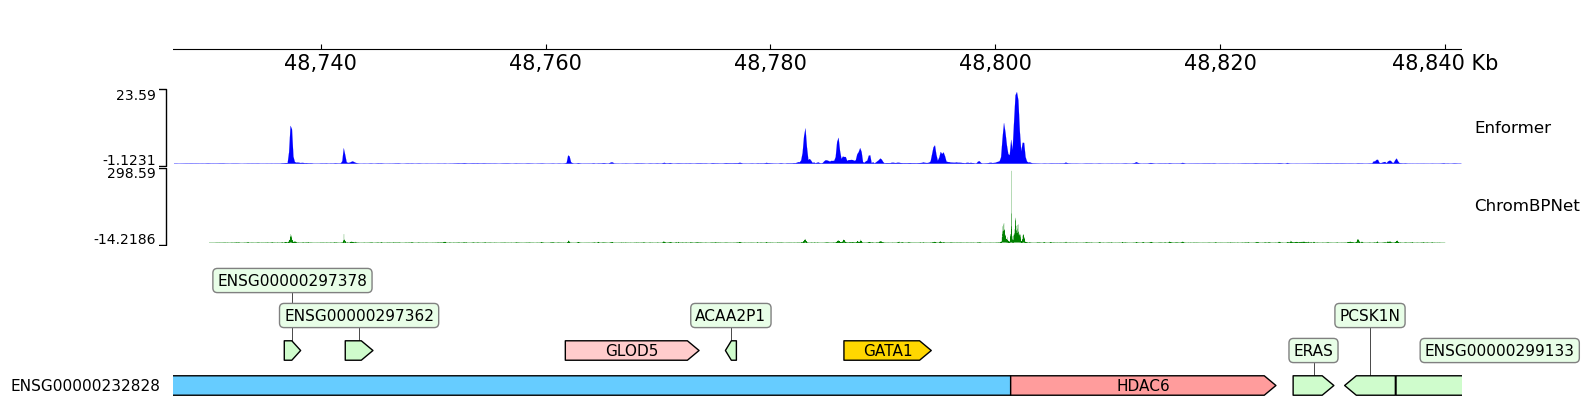

In [17]:
from coolbox.api import *

# Load enformer track
enformer_track = BedGraph(
    "./bedgraph_outputs/a_wt_ENCFF413AHU.bedgraph",
     color="blue",
     title="Enformer"
)

# Load ChromBPNet track
chrombpnet_track = BedGraph(
    "./bedgraph_outputs/a_wt_chrombpnet_DNASE_K562.bedgraph",
    color="green",
    title="ChromBPNet"
)

frame = (
    XAxis() 
    + enformer_track 
    + chrombpnet_track
    + GTF(str(gtf_path)) # input annotations
  )  

frame.plot("chrX:48726820-48841508") # plot tracks for enformer window size

## Gene Expression Analysis

First we need to get information about the **TSS** of GATA1 gene.

In [18]:
from chorus.utils import get_gene_tss

# Get TSS information for GATA1
print("Getting TSS positions for GATA1...")
gata1_tss = get_gene_tss('GATA1')
print(f"\nFound {len(gata1_tss)} transcripts for GATA1:")
for _, tss in gata1_tss.head(5).iterrows():
    print(f"  - {tss['transcript_id']} ({tss['transcript_type']}) TSS at {tss['chrom']}:{tss['tss']} ({tss['strand']})")

2025-12-01 11:14:20,804 - chorus.utils.annotations - INFO - Annotation file already exists: /storage_1/lruggeri/projects/chorus/annotations/gencode.v48.basic.annotation.gtf


Getting TSS positions for GATA1...

Found 6 transcripts for GATA1:
  - ENST00000696450.1 (protein_coding) TSS at chrX:48786540 (+)
  - ENST00000651144.2 (protein_coding) TSS at chrX:48786562 (+)
  - ENST00000696451.1 (protein_coding) TSS at chrX:48786562 (+)
  - ENST00000696452.1 (protein_coding) TSS at chrX:48786562 (+)
  - ENST00000376665.4 (protein_coding) TSS at chrX:48786573 (+)


For each transcript, we then extract the CAGE signal at the TSS.

In [19]:
from chorus.core.result import analyze_gene_expression

print("\nAnalyzing GATA1 expression from predictions...")
expression_analysis = analyze_gene_expression(
    predictions=wt_results,
    gene_name='GATA1',
    gtf_file=str(gtf_path),
    cage_track_ids=['CNhs11250']  # Focus on CAGE track
)

print(f"\nGATA1 Expression Analysis:")
print(f"  Number of TSS in region: {expression_analysis['n_tss']}")
print(f"  TSS positions in output window: {expression_analysis['tss_positions']}")
print(f"\n  Predicted CAGE expression:")
for track_id, mean_expr in expression_analysis['mean_expression'].items():
    max_expr = expression_analysis['max_expression'][track_id]
    print(f"    {track_id}: mean={mean_expr:.2f}, max={max_expr:.2f}")


Analyzing GATA1 expression from predictions...

GATA1 Expression Analysis:
  Number of TSS in region: 6
  TSS positions in output window: [48786540, 48786562, 48786562, 48786562, 48786573, 48786590]

  Predicted CAGE expression:
    CNhs11250: mean=120.81, max=120.81


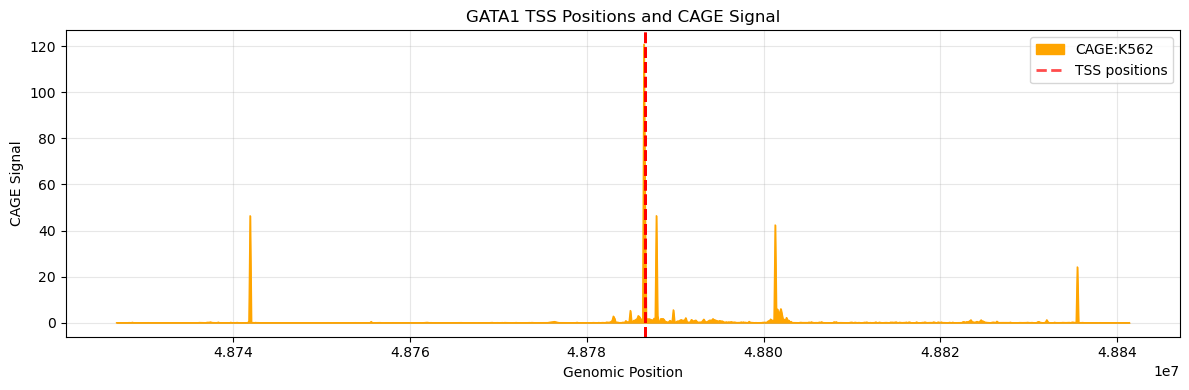

In [20]:
# Visualize TSS locations
if expression_analysis['tss_positions']:
    fig, ax = plt.subplots(figsize=(12, 4))
    
    # Plot CAGE signal
    cage_predictions = wt_results['CNhs11250']
    positions = cage_predictions.positions
    
    ax.fill_between(positions, cage_predictions.values, color='orange', label='CAGE:K562')
    ax.plot(positions, cage_predictions, color='orange', linewidth=1)
        
    # Mark TSS positions
    for tss_pos in expression_analysis['tss_positions']:
        ax.axvline(x=tss_pos, color='red', linestyle='--', alpha=0.7, linewidth=2)
    
    # Add dummy line for legend
    ax.axvline(x=expression_analysis['tss_positions'][0], color='red', linestyle='--', alpha=0.7, linewidth=2, label='TSS positions')
    
    ax.set_xlabel('Genomic Position')
    ax.set_ylabel('CAGE Signal')
    ax.set_title('GATA1 TSS Positions and CAGE Signal')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


## Example B: Region Replacement

Now let's say that we want to measure the effect of a sequence injected in our interval.

In [21]:
# Define replacement parameters
replace_region = "chrX:48782929-48783129"
replacement_seq = "CTGCTTGCTTTAGCTTCAGGGTTCTTATCTTTTTTCATTTTATAACAGCAAAGGCGACACCCAACATGTGCGTGCTTGAGATAATGACTAAAAACTGCCCGTGACTCAAGCGCTTCTGGTGAGGGAAGATAAGGCAAGGAAACTGGCCGCCTAGATAGCCCTGGGAATGAGGCAGTCTCTGTTCTGGGTAAAGTGTCTGC"

print(f"Replacing region: {replace_region}")
print(f"Original region length: 200 bp")
print(f"Replacement sequence length: {len(replacement_seq)} bp")
print(f"\nReplacement sequence (first 50 bp): {replacement_seq[:50]}...")

Replacing region: chrX:48782929-48783129
Original region length: 200 bp
Replacement sequence length: 200 bp

Replacement sequence (first 50 bp): CTGCTTGCTTTAGCTTCAGGGTTCTTATCTTTTTTCATTTTATAACAGCA...


You can predict the effect of the region replacement just by using `predict_region_replacement` method on your **oracle**.

In [22]:
# Make predictions with replacement
print("Making predictions with replaced region...\n")
replacement_results = oracle.predict_region_replacement(
    genomic_region=replace_region,
    seq=replacement_seq,
    assay_ids=track_ids,  # Using specific track IDs
    genome=str(genome_path)
)

# Save predictions to bedgraph file
replacement_files = replacement_results["raw_predictions"].save_predictions_as_bedgraph(
    output_dir="bedgraph_outputs",
    prefix="replacement_enformer"
)

Making predictions with replaced region...



Now analyze the changes.

In [23]:
# Analyze changes
print("Signal changes due to replacement:")
for track_id in track_ids:
    predictions = replacement_results['normalized_scores'][track_id]
    print(f"\n{track_id}:")
    print(f"  Mean signal: {np.mean(predictions.values):.4f}")
    print(f"  Max signal: {np.max(predictions.values):.4f}")

Signal changes due to replacement:

ENCFF413AHU:
  Mean signal: 0.0234
  Max signal: 1.0000

CNhs11250:
  Mean signal: 0.0045
  Max signal: 1.0000



Visualizing replacement effects with gene annotations...


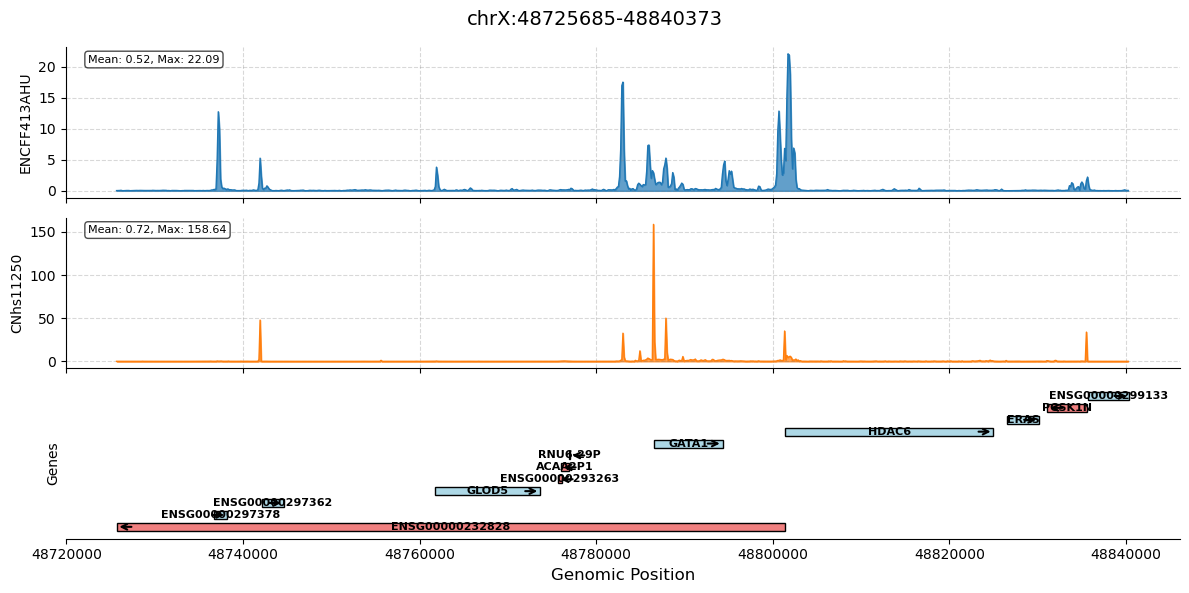

In [24]:
# Visualize replacement results with gene annotations
print("\nVisualizing replacement effects with gene annotations...")
try:
    visualize_chorus_predictions(
        predictions=replacement_results['raw_predictions'],
        track_ids=track_ids,
        output_file=None,
        figsize=(12, 6),
        gtf_file=str(gtf_path),  # Add gene annotations
        use_pygenometracks=False  # Use pyGenomeTracks
    )
    # print("Saved visualization to: replacement_with_genes.png")
    # from IPython.display import Image, display
    # display(Image('replacement_with_genes.png', width=800))
except:
    # Fallback to matplotlib
    visualize_chorus_predictions(
        predictions=replacement_results['raw_predictions'],
        track_ids=track_ids,
        output_file=None,
        figsize=(12, 6),
        gtf_file=str(gtf_path),
        use_pygenometracks=False
    )

And again, you can replicate the analysis with ChromBPNet (using only the DNASE-seq track). Here since ChromBPNet has a narrower context window, we manually inject the sequence in the desired interval and collect predictions.

In [25]:
from chorus.core.interval import Interval, GenomeRef

chrombpnet_tracks = ["DNASE:K562"]

replace_region = (48782929, 48783129)
replace_region_length = replace_region[1] - replace_region[0]

interval = Interval.make(GenomeRef(chrom="chrX", start=48_730_000, end=48_840_000, fasta=str(genome_path)))
region_interval = interval.replace(
    seq=replacement_seq,
    start=replace_region[0] - interval.reference.start,
    end=replace_region[0] - interval.reference.start + replace_region_length
)

# Get predictions for the full context
predictions = chrombpnet_oracle.predict(
    region_interval, 
    chrombpnet_tracks
)

# Save predictions as bedgraph
chrombpnet_files = predictions.save_predictions_as_bedgraph(
    output_dir="bedgraph_outputs",
    prefix="replacement_chrombpnet"
)


Visualizing replacement effects with gene annotations...


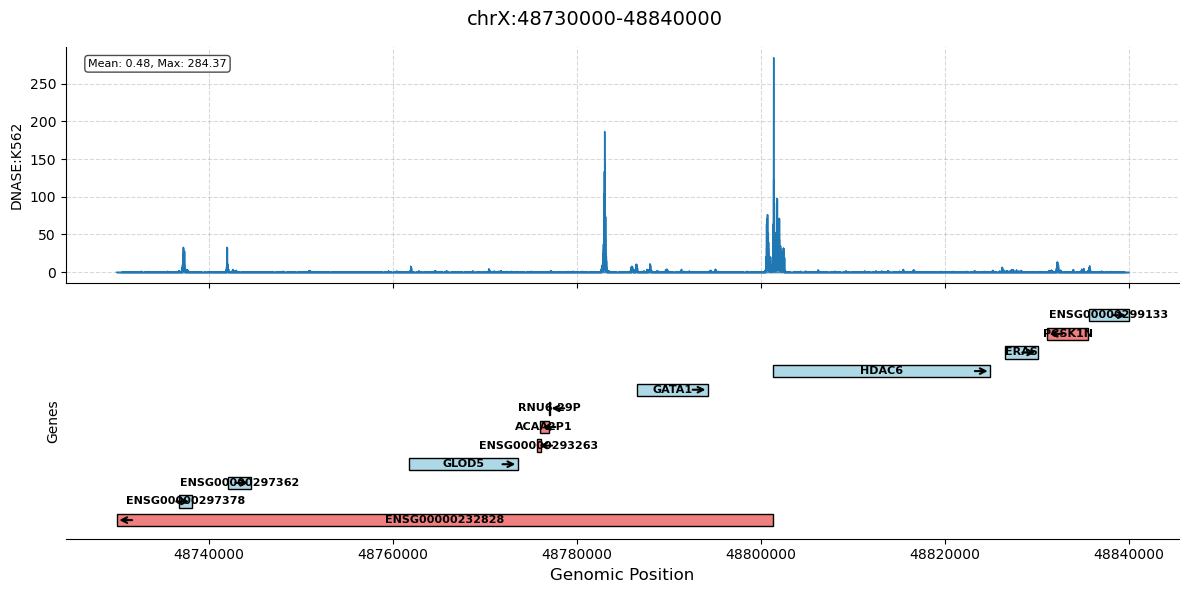

In [26]:
# Visualize replacement results with gene annotations
print("\nVisualizing replacement effects with gene annotations...")
try:
    visualize_chorus_predictions(
        predictions=predictions,
        track_ids=chrombpnet_tracks,
        output_file=None,
        figsize=(12, 6),
        gtf_file=str(gtf_path),  # Add gene annotations
        use_pygenometracks=False  # Use pyGenomeTracks
    )
    # print("Saved visualization to: replacement_with_genes.png")
    # from IPython.display import Image, display
    # display(Image('replacement_with_genes.png', width=800))
except:
    # Fallback to matplotlib
    visualize_chorus_predictions(
        predictions=predictions,
        track_ids=chrombpnet_tracks,
        output_file=None,
        figsize=(12, 6),
        gtf_file=str(gtf_path),
        use_pygenometracks=False
    )

And again you can use **coolbox** to visualize all tracks together with the replacement effect in just *few* lines of code.

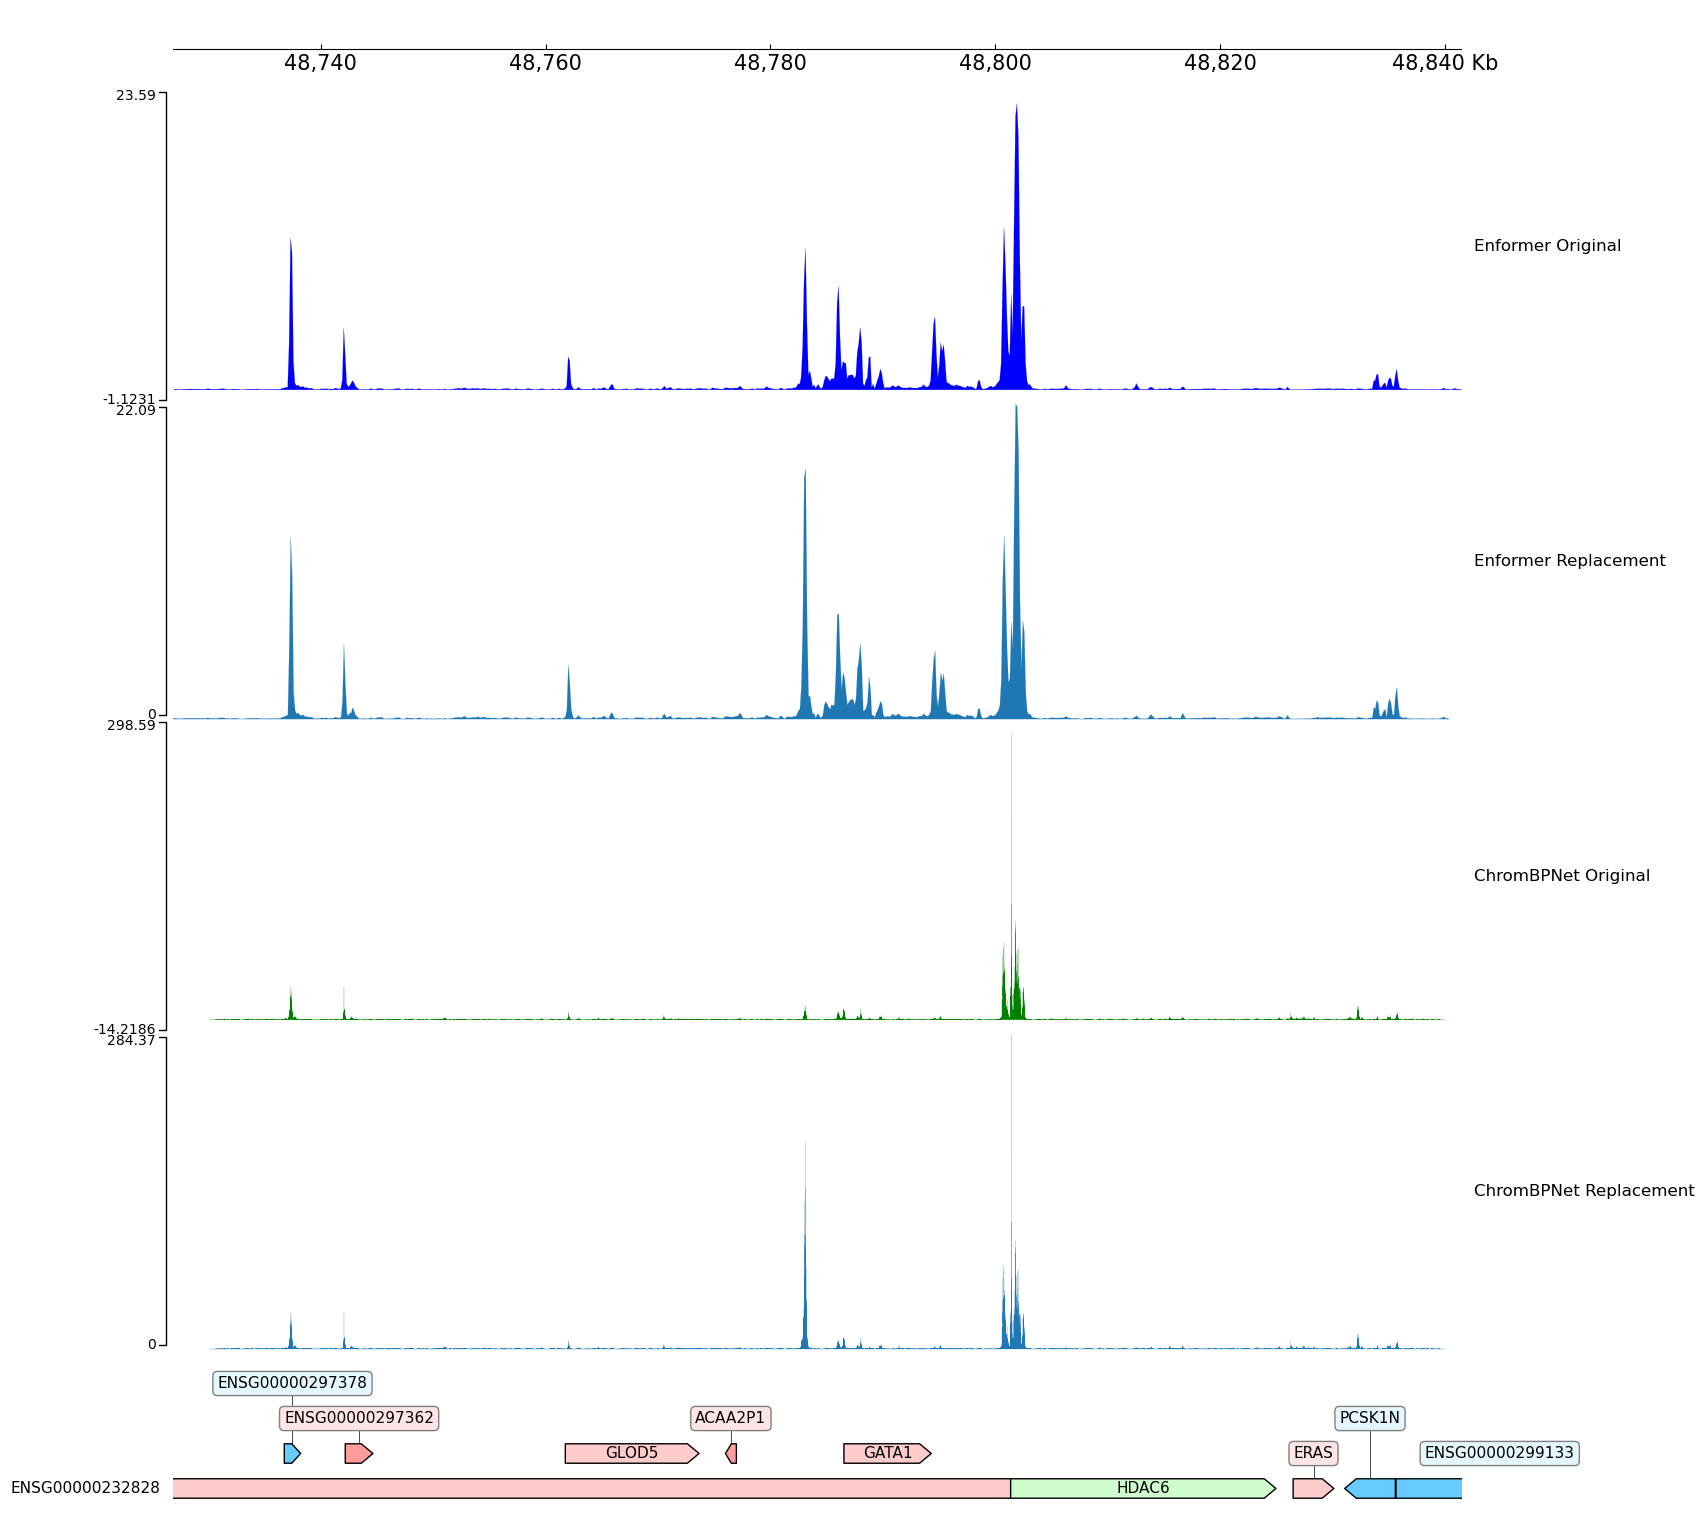

In [ ]:
from coolbox.api import *

# Load enformer tracks from bedgraph file
enformer_track = BedGraph(
    "./bedgraph_outputs/a_wt_ENCFF413AHU.bedgraph",
     color="blue",
     title="Enformer Original"
)

# Load ChromBPNet tracks from bedgraph file
chrombpnet_track = BedGraph(
    "./bedgraph_outputs/a_wt_chrombpnet_DNASE_K562.bedgraph",
    color="green",
    title="ChromBPNet Original"
)

frame = (
    XAxis() 
    + enformer_track 
    + TrackHeight(8)
    + replacement_results["raw_predictions"][track_ids[0]].get_coolbox_representation(
        add_xaxis=False,
        add_vlines=False,
        title="Enformer Replacement"
    )
    + chrombpnet_track
    + TrackHeight(8)
    + predictions[chrombpnet_tracks[0]].get_coolbox_representation(
        add_xaxis=False,
        add_vlines=False,
        title="ChromBPNet Replacement"
    )
    + GTF(str(gtf_path)) # input annotations    
  )  

frame.plot("chrX:48726820-48841508") # plot tracks for enformer window size

# Example C: Variant Effect Analysis

Explore the effect of variants injected in specific positions.

We can do this easily by using `predict_variant_effect` method on the **oracle**.

In [50]:
# Define variant to test
variant_pos = 48786129
ref_seq = 'T'  # Corrected reference allele from 'G' to 'C'

print(f"Testing variant at chrX:{variant_pos}")
print(f"Reference allele: {ref_seq}")

# Create alleles list with reference first, then alternatives
alt_alleles = [a for a in ['A', 'C', 'G', 'T'] if a != ref_seq]
test_alleles = [ref_seq] + alt_alleles  # Reference first, then alternatives

print(f"Testing substitutions: {ref_seq} -> {', '.join(alt_alleles)}")

# Need a wider region for variant analysis
print("\nPredicting variant effects...\n")
variant_results = oracle.predict_variant_effect(
    genomic_region=f"chrX:{variant_pos-5000}-{variant_pos+5000}",
    variant_position=f"chrX:{variant_pos}",
    alleles=test_alleles,  # Reference first, then alternatives
    assay_ids=track_ids,  # Using specific track IDs
    genome=str(genome_path)
)

print("\nVariant predictions completed!")

Testing variant at chrX:48786129
Reference allele: T
Testing substitutions: T -> A, C, G

Predicting variant effects...


Variant predictions completed!


In [53]:
# Create a report for the variant effects
# Analyze variant effects
print("Variant effect analysis:")
print("=" * 60)

# Create results dataframe
variant_effects = []

# Check the structure first
print(f"\nVariant results keys: {variant_results.keys()}")
print(f"Predictions keys: {variant_results['predictions'].keys()}")

# Get reference predictions - it's a dictionary, not a 2D array
ref_predictions = variant_results['predictions']['reference']
print(f"\nReference predictions type: {type(ref_predictions)}")
if isinstance(ref_predictions, dict):
    print(f"Track IDs in predictions: {list(ref_predictions.keys())}")

for track_id in track_ids:
    # Get reference signal for this track
    ref_signal = np.mean(ref_predictions[track_id].values)
    
    print(f"\n{track_id}:")
    print(f"  Reference ({ref_seq}) mean signal: {ref_signal:.4f}")
    print("  Variant effects:")
    
    # Add reference to dataframe
    variant_effects.append({
        'Track': track_id,
        'Allele': ref_seq,
        'Signal': ref_signal,
        'Effect': 0.0,
        'Is_Reference': True
    })
    
    # Add alternatives
    for i, allele in enumerate(alt_alleles):
        allele_key = f'alt_{i+1}'
        if allele_key in variant_results['predictions']:
            alt_predictions = variant_results['predictions'][allele_key]
            alt_signal = np.mean(alt_predictions[track_id].values)
            effect = alt_signal - ref_signal
            print(f"    {allele}: {alt_signal:.4f} (Δ = {effect:+.4f})")
            
            variant_effects.append({
                'Track': track_id,
                'Allele': allele,
                'Signal': alt_signal,
                'Effect': effect,
                'Is_Reference': False
            })

# Create DataFrame for easier analysis
variant_df = pd.DataFrame(variant_effects)
variant_df

Variant effect analysis:

Variant results keys: dict_keys(['predictions', 'effect_sizes', 'variant_info'])
Predictions keys: dict_keys(['reference', 'alt_1', 'alt_2', 'alt_3'])

Reference predictions type: <class 'chorus.core.result.OraclePrediction'>

ENCFF413AHU:
  Reference (T) mean signal: 0.4455
  Variant effects:
    A: 0.4463 (Δ = +0.0008)
    C: 0.4467 (Δ = +0.0012)
    G: 0.4458 (Δ = +0.0003)

CNhs11250:
  Reference (T) mean signal: 0.5346
  Variant effects:
    A: 0.5371 (Δ = +0.0025)
    C: 0.5401 (Δ = +0.0055)
    G: 0.5329 (Δ = -0.0017)


,Track,Allele,Signal,Effect,Is_Reference
0,ENCFF413AHU,T,0.445504,0.000000,True
1,ENCFF413AHU,A,0.446308,0.000803,False
2,ENCFF413AHU,C,0.446733,0.001229,False
3,ENCFF413AHU,G,0.445779,0.000274,False
4,CNhs11250,T,0.534630,0.000000,True
5,CNhs11250,A,0.537084,0.002454,False
6,CNhs11250,C,0.540127,0.005497,False
7,CNhs11250,G,0.532894,-0.001736,False


Creating detailed variant comparison...
Reference predictions type: <class 'chorus.core.result.OraclePrediction'>
Prediction shape for each track: (896,)
Variant position 48786129 is at bin 448 in the output


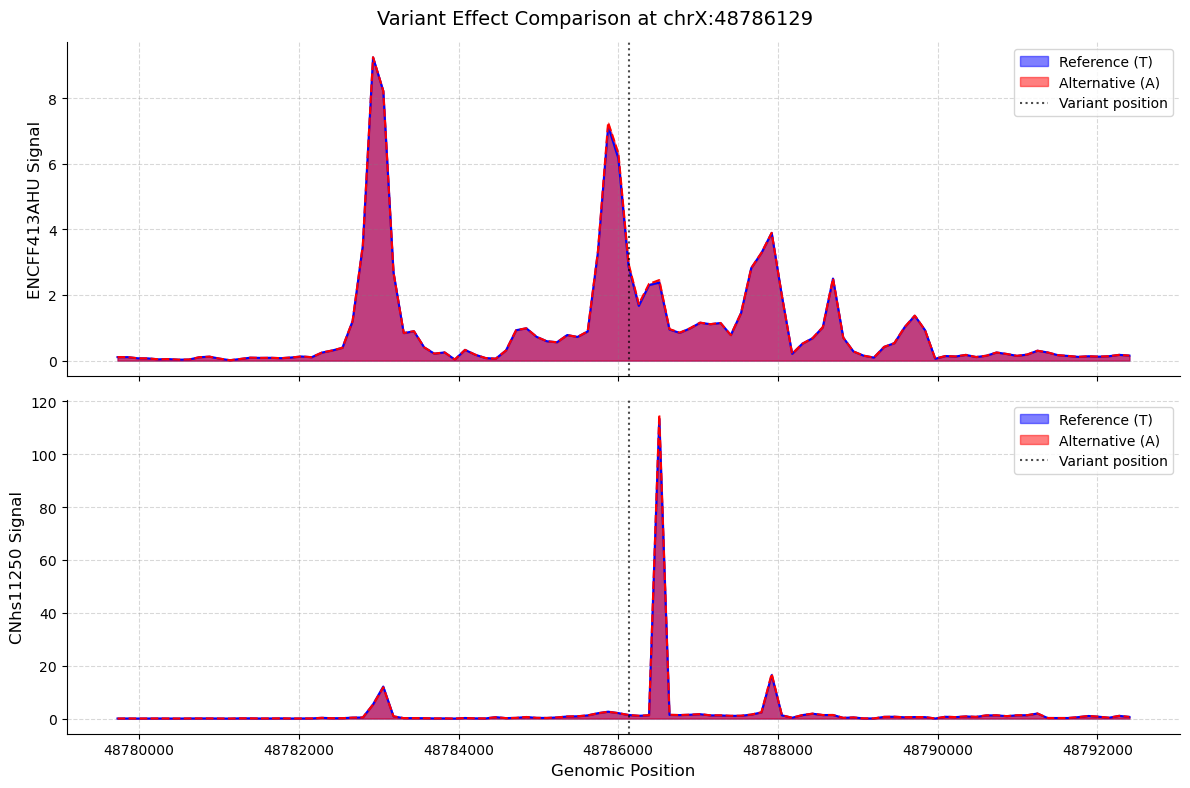

In [54]:
# Create a detailed variant comparison visualization
print("Creating detailed variant comparison...")

# First, let's check the shape of the predictions
ref_predictions = variant_results['predictions']['reference']
print(f"Reference predictions type: {type(ref_predictions)}")

# Get the shape from one of the tracks
ref_shape = ref_predictions[track_ids[0]].values.shape
print(f"Prediction shape for each track: {ref_shape}")

# The predictions are for the full output window (896 bins)
# We need to find where the variant position falls within this window

# Get the genomic coordinates of the output window
variant_region_center = variant_pos  # Since we used a region centered on the variant
track = next(iter(variant_results['predictions']['reference'].values()))
interval = track.prediction_interval
output_start, output_end = interval.reference.start,  interval.reference.end

# Calculate where the variant falls in the output
variant_bin = (variant_pos - output_start) //  track.resolution
print(f"Variant position {variant_pos} is at bin {variant_bin} in the output")

# Focus on a window around the variant
variant_window_size = 50  # bins on each side
window_start = max(0, variant_bin - variant_window_size)
window_end = min(ref_shape[0], variant_bin + variant_window_size)

# Create comparison plot
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True, facecolor='white')

for idx, (track_id, ax) in enumerate(zip(track_ids, axes)):
    # Plot reference - access by track_id
    ref_values = variant_results['predictions']['reference'][track_id].values[window_start:window_end]
    positions = np.arange(len(ref_values)) * track.resolution + output_start + window_start * track.resolution
    ax.fill_between(positions, ref_values, alpha=0.5, color='blue', label=f'Reference ({ref_seq})')
    ax.plot(positions, ref_values, color='blue', linewidth=1.5)
    
    # Plot first alternative
    alt_values = variant_results['predictions']['alt_1'][track_id].values[window_start:window_end]
    ax.fill_between(positions, alt_values, alpha=0.5, color='red', label=f'Alternative ({alt_alleles[0]})')
    ax.plot(positions, alt_values, color='red', linewidth=1.5, linestyle='--')
    
    # Mark variant position
    ax.axvline(x=variant_pos, color='black', linestyle=':', alpha=0.7, label='Variant position')
    
    ax.set_ylabel(f'{track_id} Signal', fontsize=12)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3, color='gray', linestyle='--')
    ax.set_facecolor('white')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[-1].set_xlabel('Genomic Position', fontsize=12)
axes[-1].ticklabel_format(style='plain', axis='x')
fig.suptitle(f'Variant Effect Comparison at chrX:{variant_pos}', fontsize=14)
plt.tight_layout()

# Display the figure
from IPython.display import display
display(fig)
plt.close()  # Close to free memory

And, of course, you can do the same with ChromBPNet!

In [55]:
print("\nPredicting variant effects...\n")
variant_results = chrombpnet_oracle.predict_variant_effect(
    genomic_region=f"chrX:{variant_pos-5000}-{variant_pos+5000}",
    variant_position=f"chrX:{variant_pos}",
    alleles=test_alleles,  # Reference first, then alternatives
    assay_ids=chrombpnet_tracks,  # Using specific track IDs
    genome=str(genome_path)
)

print("\nVariant predictions completed!")


Predicting variant effects...


Variant predictions completed!


In [56]:
# Create a report for the variant effects
# Analyze variant effects
print("Variant effect analysis:")
print("=" * 60)

# Create results dataframe
variant_effects = []

# Check the structure first
print(f"\nVariant results keys: {variant_results.keys()}")
print(f"Predictions keys: {variant_results['predictions'].keys()}")

# Get reference predictions - it's a dictionary, not a 2D array
ref_predictions = variant_results['predictions']['reference']
print(f"\nReference predictions type: {type(ref_predictions)}")
if isinstance(ref_predictions, dict):
    print(f"Track IDs in predictions: {list(ref_predictions.keys())}")

for track_id in chrombpnet_tracks:
    # Get reference signal for this track
    ref_signal = np.mean(ref_predictions[track_id].values)
    
    print(f"\n{track_id}:")
    print(f"  Reference ({ref_seq}) mean signal: {ref_signal:.4f}")
    print("  Variant effects:")
    
    # Add reference to dataframe
    variant_effects.append({
        'Track': track_id,
        'Allele': ref_seq,
        'Signal': ref_signal,
        'Effect': 0.0,
        'Is_Reference': True
    })
    
    # Add alternatives
    for i, allele in enumerate(alt_alleles):
        allele_key = f'alt_{i+1}'
        if allele_key in variant_results['predictions']:
            alt_predictions = variant_results['predictions'][allele_key]
            alt_signal = np.mean(alt_predictions[track_id].values)
            effect = alt_signal - ref_signal
            print(f"    {allele}: {alt_signal:.4f} (Δ = {effect:+.4f})")
            
            variant_effects.append({
                'Track': track_id,
                'Allele': allele,
                'Signal': alt_signal,
                'Effect': effect,
                'Is_Reference': False
            })

# Create DataFrame for easier analysis
variant_df = pd.DataFrame(variant_effects)
variant_df

Variant effect analysis:

Variant results keys: dict_keys(['predictions', 'effect_sizes', 'variant_info'])
Predictions keys: dict_keys(['reference', 'alt_1', 'alt_2', 'alt_3'])

Reference predictions type: <class 'chorus.core.result.OraclePrediction'>

DNASE:K562:
  Reference (T) mean signal: 0.4242
  Variant effects:
    A: 0.4227 (Δ = -0.0014)
    C: 0.4247 (Δ = +0.0006)
    G: 0.4261 (Δ = +0.0019)


,Track,Allele,Signal,Effect,Is_Reference
0,DNASE:K562,T,0.424151,0.000000,True
1,DNASE:K562,A,0.422723,-0.001428,False
2,DNASE:K562,C,0.424736,0.000585,False
3,DNASE:K562,G,0.426091,0.001940,False


Creating detailed variant comparison...
Reference predictions type: <class 'chorus.core.result.OraclePrediction'>
Prediction shape for each track: (10000,)
Variant position 48786129 is at bin 5000 in the output


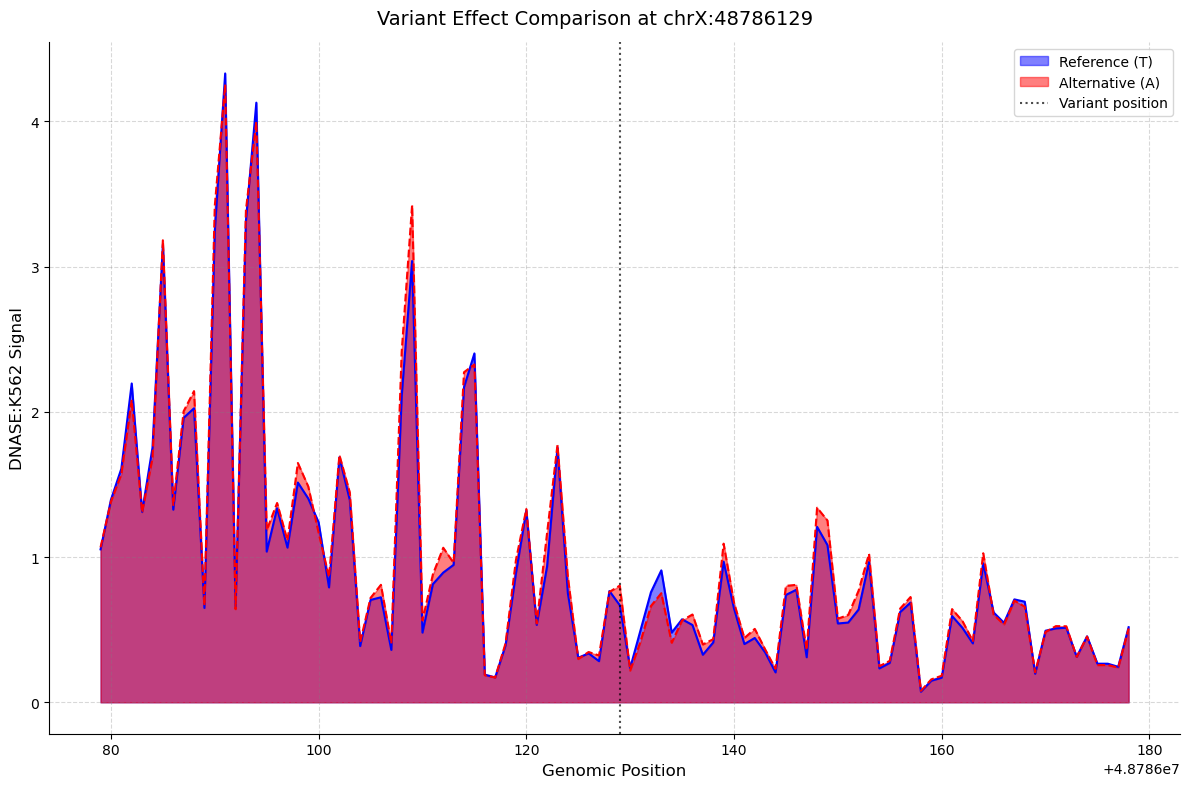

In [57]:
# Create a detailed variant comparison visualization
print("Creating detailed variant comparison...")

# First, let's check the shape of the predictions
ref_predictions = variant_results['predictions']['reference']
print(f"Reference predictions type: {type(ref_predictions)}")

# Get the shape from one of the tracks
ref_shape = ref_predictions[chrombpnet_tracks[0]].values.shape
print(f"Prediction shape for each track: {ref_shape}")

# The predictions are for the full output window (896 bins)
# We need to find where the variant position falls within this window

# Get the genomic coordinates of the output window
variant_region_center = variant_pos  # Since we used a region centered on the variant
track = next(iter(variant_results['predictions']['reference'].values()))
interval = track.prediction_interval
output_start, output_end = interval.reference.start,  interval.reference.end

# Calculate where the variant falls in the output
variant_bin = (variant_pos - output_start) //  track.resolution
print(f"Variant position {variant_pos} is at bin {variant_bin} in the output")

# Focus on a window around the variant
variant_window_size = 50  # bins on each side
window_start = max(0, variant_bin - variant_window_size)
window_end = min(ref_shape[0], variant_bin + variant_window_size)

# Create comparison plot
fig, axes = plt.subplots(len(chrombpnet_tracks), 1, figsize=(12, 8), sharex=True, facecolor='white')

# Handle single axes case
if not isinstance(axes, np.ndarray):
    axes = [axes]

for idx, (track_id, ax) in enumerate(zip(chrombpnet_tracks, axes)):
    # Plot reference - access by track_id
    ref_values = variant_results['predictions']['reference'][track_id].values[window_start:window_end]
    positions = np.arange(len(ref_values)) * track.resolution + output_start + window_start * track.resolution
    ax.fill_between(positions, ref_values, alpha=0.5, color='blue', label=f'Reference ({ref_seq})')
    ax.plot(positions, ref_values, color='blue', linewidth=1.5)
    
    # Plot first alternative
    alt_values = variant_results['predictions']['alt_1'][track_id].values[window_start:window_end]
    ax.fill_between(positions, alt_values, alpha=0.5, color='red', label=f'Alternative ({alt_alleles[0]})')
    ax.plot(positions, alt_values, color='red', linewidth=1.5, linestyle='--')
    
    # Mark variant position
    ax.axvline(x=variant_pos, color='black', linestyle=':', alpha=0.7, label='Variant position')
    
    ax.set_ylabel(f'{track_id} Signal', fontsize=12)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3, color='gray', linestyle='--')
    ax.set_facecolor('white')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[-1].set_xlabel('Genomic Position', fontsize=12)
axes[-1].ticklabel_format(style='plain', axis='x')
fig.suptitle(f'Variant Effect Comparison at chrX:{variant_pos}', fontsize=14)
plt.tight_layout()

# Display the figure
from IPython.display import display
display(fig)
plt.close()  # Close to free memory